# Comparing Western vs Arab Readers

The notebook scrapes reviews from Goodreads to find books that are preferred by Western vs Arabic readers. The most easy-to-use function is "Show Comparison." Give a Title, and see how people rated it in Arabic and English. Put in Goodreads API Key here:

In [44]:
api_key = 'Goodreads Api Key'

In [40]:
import requests
from xml.etree import ElementTree as ET
import urllib.request
from bs4 import BeautifulSoup
import unicodedata
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
from scipy.stats import ttest_ind
%matplotlib inline

In [28]:
#Maps manually from author name to Goodreads author ID. To get this, search an author in goodreads and find the id in the 
#url 
author_map = {'Brown': 630,
 'Hemingway': 1455,
 'Qutb': 8076193,
 'Rowling': 1077326,
 'Shakespeare': 947,
 'Rumi': 875661,
 'al-Banna': 13426768,
'Orwell' : 3706,
'Tolkien' : 656983,
'Lewis' : 1069006,
'Said' : 16770310,
'Darwish' : 75055,
 'Kerouac' :  1742,
'Barghouti' : 16083673}

In [29]:
#Books identified so far that are liked more by Western or Arabic readers 

cultural_difference_books = ['The New Life', 'Persian Girls', 'palace walk',
       'season of migration to the north', 'Frankenstein in Baghdad',
       'ليالي ألف ليلة', 'The Yacoubian Building', 'The Map of Love',
       'The Alchemist', 'Arabian Nights and Days', 'Midaq Alley',
       "Monsieur Ibrahim and The Flowers of the Qur'an",
       "The Architect's Apprentice", "The Architect's Apprentice",
       'Divan of Hafez: دیوان خواجه شمس الدین محمد حافظ شیرازی',
       'Girls of Riyadh']

In [37]:
#Gets Widget URL and image URL from book title
def getURLSfromTitle(book_title):
    payload = {'key': api_key, 'title': book_title}
    book_request = requests.get('https://www.goodreads.com/book/title.xml', params=payload).text
    book_request_xml = ET.fromstring(book_request)
    image_url = book_request_xml.find('./book/small_image_url').text
    
    widget_html = book_request_xml.find('./book/reviews_widget').text
    widget_url = BeautifulSoup(widget_html,'html.parser').iframe['src']
    
    return image_url, widget_url

In [31]:
#Returns Reviews from URL. Ugly web scraping 
def getReviewsfromUrl(widget_url,number_pages = 10):
    base_url = widget_url + '&num_reviews=50'
    
    
    def raw_reviews_from_url(base_url,page_number):
        
        url = base_url + '&page=' + str(page_number)
        reviews_html_raw = requests.get(url)
        reviews_html = BeautifulSoup(reviews_html_raw.text,'html.parser')
     
        return reviews_html.findAll('div',{"class": "gr_review_container"})
        
        
    def parse_review(review):
        rating = review.find('span',{"class": "gr_rating"})
        #user = review.find('span',{"class": "gr_review_by"})
        comment = review.find('div',{"class": "gr_review_text"})
        if rating and comment:
            return rating.text,comment.text.replace('...more','').strip()
        else:
            return None
         
    raw_review_pages = [raw_reviews_from_url(base_url,page_number) for page_number in range(1,number_pages + 1)]
    
    review_tuples = [parse_review(review) for raw_review_page in raw_review_pages for review in raw_review_page]
    return [review for review in review_tuples if review]
    

In [32]:
#determines if text is arabic
def text_is_arabic(text):
    return any(['arabic' in unicodedata.name(letter).lower() for letter in text.strip()[5:10]])

In [33]:
#Go from review to seperate statistics for arab and western readers 
def transform_review(review):
        return (text_is_arabic(review[1]),review[0].count('★'))
    
def map_to_stats(review_tuples):
    
    reviews = list(map(lambda x: transform_review(x),review_tuples))
    arab_stats = list(filter(lambda x: x[0],reviews))
    west_stats = list(filter(lambda x: not x[0],reviews))
    
    arab_stats = list(map(lambda x: x[1],arab_stats))
    west_stats = list(map(lambda x: x[1],west_stats))

    return arab_stats, west_stats

In [34]:
#Makes histogram out of arab stats and western stats 
def makeHist(arab_stats,west_stats,title,image_url):    
    
    if len(west_stats) > 0:
        west_mean = "{:.1f}".format(np.array(west_stats).mean())
        plt.hist(west_stats, label = 'Latin: Mean = %s' %west_mean + ' and Count = %i' %len(west_stats))
        
    if len(arab_stats) > 0:
        arab_mean = "{:.1f}".format(np.array(arab_stats).mean())
        plt.hist(arab_stats, label = 'Arabic: Mean = %s' %arab_mean + ' and Count = %i' %len(arab_stats), fc=(0, 0, 0, 0.5))

    plt.title(title)
    plt.legend()
    display(Image(image_url))
    plt.show()



In [11]:
#aggregate function goes from title to stats
def getStats(title):
    image_url, widget_url = getURLSfromTitle(title)
    review_tuples = getReviewsfromUrl(widget_url)
    arab_stats, west_stats = map_to_stats(review_tuples)
    return arab_stats,west_stats
    

In [12]:
### Probably the most interesting. Feed a title, and get a Histogram! 
def showComparison(title):
    image_url, widget_url = getURLSfromTitle(title)
    review_tuples = getReviewsfromUrl(widget_url)
    arab_stats, west_stats = map_to_stats(review_tuples)
    makeHist(arab_stats,west_stats,title,image_url)

In [38]:
### go from author to histograms of the first books on Goodreads. Need to input an author who is in the "author map." 
#To do this, type an author into goodreads and get the number in between the slashes in the url. then add it to the 
#author map you see above in the same format.

def booksFromAuthor(author,number_results = 5):
    author_id = author_map[author]
    payload = {'key': api_key, 'id': author_id}
    author_api = requests.get('https://www.goodreads.com/author/list.xml', params=payload).text
    author_xml = ET.fromstring(author_api)
    
    i = 0
    for book in author_xml.iter('book'):
        if(int(book.find('ratings_count').text) > 1000):
            i+=1
            title = book.find('title').text
            print(title)
            showComparison(title)
        
        if i>number_results:
            break     

In [14]:
#Determines if there is a statistically significant difference between arab/western readers' reviews 
def cultureDifference(arab_stats,west_stats):
    if len(arab_stats) < 100 or len(west_stats) < 100:
        return False
  
    p_value = ttest_ind(arab_stats,west_stats)[1]
    return p_value < 0.05

In [26]:
#Given list of books, filter for only books with difference between readers
def filterBook(book):
    stats = getStats(book)
    return cultureDifference(stats[0],stats[1])

def filterBooks(book_list):
    return list(filter(lambda x: filterBook(x),book_list))

In [16]:
#Used to extract titles from a booklist 
def getTitlesfromUrl(url,number_pages = 20):
    output = []
    base_url = url
    for page_number in range(1,number_pages):
        
        paged_url = url + '?page=%s' %page_number 
        
        html = BeautifulSoup(requests.get(paged_url).text, 'html.parser')
        titles = html.findAll('a',{"class": "bookTitle"})
        for title in titles:
            title =  title.text.replace('(Paperback)', '').strip()
            title = title.replace('(Hardcover)', '').strip()
            output.append(title)
        
    return output


In [22]:
#Given a title, if it is culturally significant, then creates a tuple all of the reviews, with whether Arab readers 
#or western readers preferred it. 

def datasetPrep(title):
    
    image_url, widget_url = getURLSfromTitle(title)
    review_tuples = getReviewsfromUrl(widget_url)
    english_reviews = list(filter(lambda x: not text_is_arabic(x[1]),review_tuples))
    english_reviews = list(map(lambda x: x[1].replace('...more','').strip(),english_reviews))
    arab_stats, west_stats = map_to_stats(review_tuples)
    if np.array(arab_stats).mean() > np.array(west_stats).mean():
        preference = 'Arab'
    else:
        preference = 'West'
        
    return [(review,preference) for review in english_reviews]    

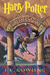

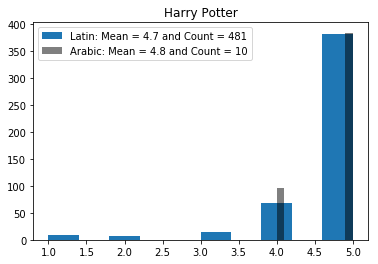

In [52]:
showComparison('Harry Potter')

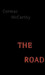

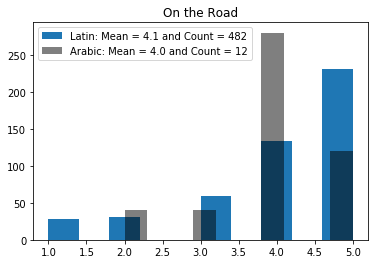

In [53]:
showComparison('On the Road')

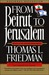

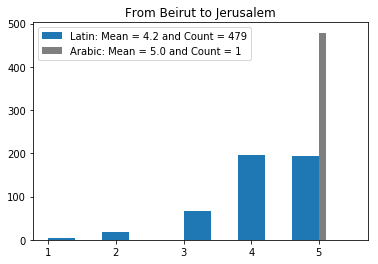

In [54]:
showComparison('From Beirut to Jerusalem')

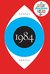

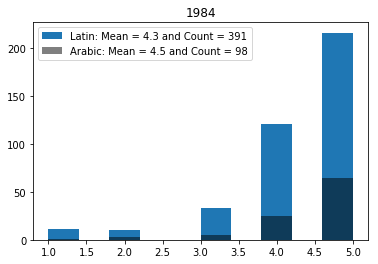

In [57]:
showComparison('1984')

1984


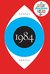

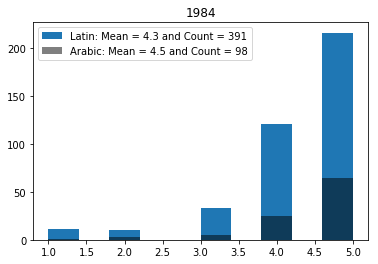

Animal Farm


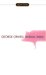

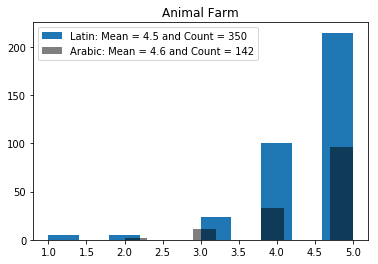

Animal Farm / 1984


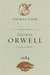

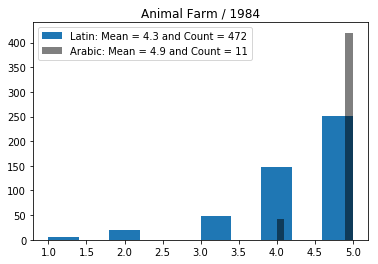

Down and Out in Paris and London


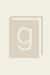

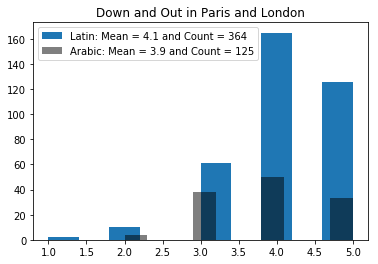

Homage to Catalonia


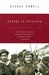

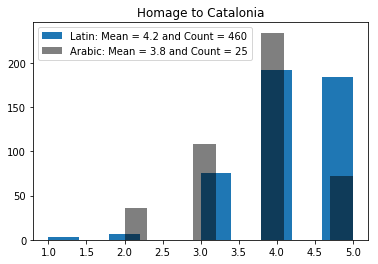

Burmese Days


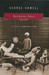

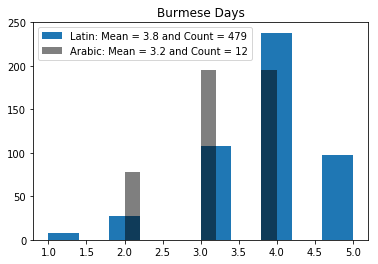

In [78]:
booksFromAuthor('Orwell')

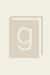

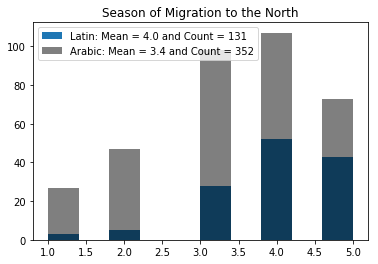

In [277]:
showComparison('Season of Migration to the North')

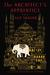

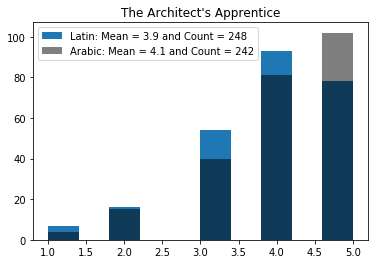

In [43]:
showComparison("The Architect's Apprentice")

# Data Analysis

Basic Tools For finding specific words that are more common in Arab/Western preference books. Will need way more data before I can do anything useful.

In [299]:
def topWords(data, num_words = 50):
    words = data['Comment'].str.cat().split()
    total = len(words)
    word_count = dict(collections.Counter(words))
    word_count = {k:v/total for k,v in word_count.items()}

    top_50_words = sorted(word_count.items(), key=lambda kv: kv[1], reverse = True)[:num_words]
    top_50_words = dict(top_50_words)

    return top_50_words

def comparisonDic(dic1,dic2):
    new_dic = {k: v/dic1[k] for k,v in dic2.items() if k in dic1.keys()}
    return new_dic

In [300]:
def getWordDifferences(data,num_words = 50):
    arab = data.loc[data['Pref'] == 'Arab']
    west = data.loc[data['Pref'] == 'West']
    
    arab_words = topWords(arab,num_words)
    west_words = topWords(west,num_words)
    
    combo_dic = comparisonDic(arab_words,west_words)
    combo_dic = sorted(combo_dic.items(), key=lambda kv: kv[1], reverse = True)
    
    return combo_dic